In [ ]:
# Load libraries

from __future__ import absolute_import, division, print_function, unicode_literals

import stellargraph as sg
from stellargraph.mapper import FullBatchNodeGenerator, KGTripleGenerator
from stellargraph.layer import GCN, ComplEx
from stellargraph import StellarDiGraph


try:
    sg.utils.validate_notebook_version("1.2.1")
except AttributeError:
    raise ValueError(
        f"Requires StellarGraph version 1.2.1, but version {sg.__version__} is detected."
    ) from None

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers, optimizers, losses, metrics, Model, backend as bk
from tensorflow.keras.layers import Dense, Flatten, Conv2D
print("TensorFlow version: ", tf.__version__)

import snap
import scipy.sparse as sp
import numpy as np
from sklearn import preprocessing

import collections
from collections import namedtuple
import unittest
import os

import pandas as pd
import seaborn as sns; sns.set()
import matplotlib.image as mpimg
import scipy
import pickle as pkl
import random
import time

from Bio.PDB import PDBParser
from Bio.PDB.Polypeptide import PPBuilder

from sklearn import preprocessing, model_selection
from sklearn import metrics as skm

from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_rows", 100, "display.max_columns", 100)

TensorFlow version:  2.7.0


In [ ]:
%cd /content/drive/MyDrive/_Projects/epistasis/cs229_project

/content/drive/MyDrive/_Projects/epistasis/cs229_project


In [ ]:
# PARAMETERS:

train_fraction = 0.50
val_fraction = 0.25
# test fraction is 1 - train_fraction - val_fraction

embedding_dimension = 200
negative_samples = 10

use_recips = True
save_splits = True
pretrain_with_evc = True

In [ ]:
# Capped epistasis:

DM = pd.read_csv('41588_2019_432_MOESM3_ESM.csv', header=1)

DM['m1_pos'] = DM['positions'].apply(lambda x: int(x[1:-1].split(',')[0])-226)
DM['m2_pos'] = DM['positions'].apply(lambda x: int(x[1:-1].split(',')[1])-226)
DM['m1_wt_aa'] = DM['wt.aminos'].apply(lambda x: x[1:-1].split(',')[0][1:-1])
DM['m2_wt_aa'] = DM['wt.aminos'].apply(lambda x: x[1:-1].split(',')[1][2:-1])
DM['m1_mt_aa'] = DM['mut.aminos'].apply(lambda x: x[1:-1].split(',')[0][1:-1])
DM['m2_mt_aa'] = DM['mut.aminos'].apply(lambda x: x[1:-1].split(',')[1][2:-1])

DM['dmlabel'] = DM.apply(lambda x: x.m1_mt_aa + x.m2_mt_aa, axis=1)

DM['smf1'] = DM['lnWs'].apply(lambda x: float(x[1:-1].split(',')[0]))
DM['smf2'] = DM['lnWs'].apply(lambda x: float(x[1:-1].split(',')[1]))

DM['dmf'] = DM['lnW'].apply(lambda x: float(x))

DM['epistasis'] = DM['epi'].apply(lambda x: float(x))

DM = DM.sample(frac=1)
DM = DM.reset_index(drop=True)

DM = DM.drop_duplicates(subset=['m1_wt_aa','m1_pos','m1_mt_aa','m2_wt_aa','m2_pos','m2_mt_aa'])

DM = DM[['m1_wt_aa','m1_pos','m1_mt_aa','m2_wt_aa','m2_pos','m2_mt_aa','dmlabel','smf1','smf2','dmf','epistasis']]

DM['source_mut'] = DM.apply(lambda x: str(x['m1_pos'])+x['m1_mt_aa'], axis=1)
DM['target_mut'] = DM.apply(lambda x: str(x['m2_pos'])+x['m2_mt_aa'], axis=1)


DM


,m1_wt_aa,m1_pos,m1_mt_aa,m2_wt_aa,m2_pos,m2_mt_aa,dmlabel,smf1,smf2,dmf,epistasis,source_mut,target_mut
0,V,29,T,D,47,P,TP,0.232766,0.645736,0.731641,-0.146861,29T,47P
1,T,17,D,Q,32,H,DH,-0.827605,0.138622,-0.481763,0.207220,17D,32H
2,K,13,S,A,23,R,SR,0.465493,-2.815994,-2.262662,0.087839,13S,23R
3,T,11,L,L,12,Q,LQ,-1.009958,-1.550821,-1.749793,0.810986,11L,12Q
4,E,19,W,G,41,N,WN,0.445531,-4.605170,-4.605170,-0.445531,19W,41N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
535912,L,12,H,D,47,Y,HY,-1.705547,0.553617,-1.377473,-0.225544,12H,47Y
535913,F,52,M,E,56,W,MW,-1.693693,-1.201233,-3.851874,-0.956947,52M,56W
535914,E,27,A,T,55,W,AW,-4.605170,-0.225421,-4.605170,0.000000,27A,55W
535915,L,12,T,T,53,L,TL,-1.480514,-0.586842,-2.601971,-0.534615,12T,53L


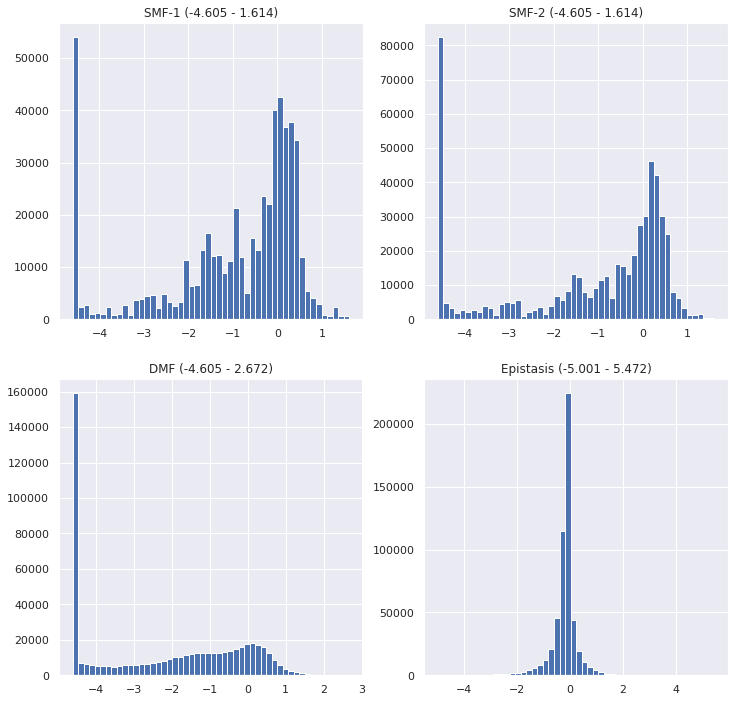

In [ ]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,
                                 sharex=False,sharey=False)
fig.set_figheight(12)
fig.set_figwidth(12)

bins=50
ax1.hist(DM.smf1,bins=bins)
ax1.set_title('SMF-1'+' ('+str(round(min(DM.smf1),3))+' - '+str(round(max(DM.smf1),3))+')')
ax2.hist(DM.smf2,bins=bins)
ax2.set_title('SMF-2'+' ('+str(round(min(DM.smf2),3))+' - '+str(round(max(DM.smf2),3))+')')
ax3.hist(DM.dmf,bins=bins)
ax3.set_title('DMF'+' ('+str(round(min(DM.dmf),3))+' - '+str(round(max(DM.dmf),3))+')')
ax4.hist(DM.epistasis,bins=bins)
ax4.set_title('Epistasis'+' ('+str(round(min(DM.epistasis),3))+' - '+str(round(max(DM.epistasis),3))+')')

plt.show()

In [ ]:
# Check normality
print(scipy.stats.normaltest(DM.epistasis.to_numpy()))

NormaltestResult(statistic=183456.68775517482, pvalue=0.0)


In [ ]:
print(np.percentile(DM.epistasis, 95))
print(np.percentile(DM.epistasis, 5))

0.4595839767999994
-1.065059871


In [ ]:
# Define edges for positive epistasis

positive_cutoff = np.percentile(DM.epistasis, 95)

positive_muts = DM.loc[DM.epistasis>positive_cutoff]
positive_muts['epi_label_positive'] = DM.apply(lambda x: 'positive', axis=1)

positive_edges = positive_muts[['source_mut','epi_label_positive','target_mut']]
positive_edges = positive_edges.rename(columns={'source_mut':'source','epi_label_positive':'type','target_mut':'target'})

positive_edges = positive_edges.reset_index(drop=True)

positive_edges

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,source,type,target
0,11L,positive,12Q
1,40I,positive,56H
2,40A,positive,56I
3,24F,positive,32I
4,9D,positive,12P
...,...,...,...
27355,12T,positive,56P
27356,10P,positive,14A
27357,29W,positive,33M
27358,7T,positive,17D


In [ ]:
# Define edges for negative epistasis

negative_cutoff = np.percentile(DM.epistasis, 5)

negative_muts = DM.loc[DM.epistasis<negative_cutoff]
negative_muts['epi_label_negative'] = DM.apply(lambda x: 'negative', axis=1)

negative_edges = negative_muts[['source_mut','epi_label_negative','target_mut']]
negative_edges = negative_edges.rename(columns={'source_mut':'source','epi_label_negative':'type','target_mut':'target'})
negative_edges = negative_edges.reset_index(drop=True)

negative_edges

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,source,type,target
0,5Q,negative,20E
1,3P,negative,51W
2,3K,negative,55Q
3,46P,negative,51Q
4,7S,negative,26T
...,...,...,...
29830,3A,negative,30L
29831,45V,negative,56V
29832,14N,negative,32Y
29833,3A,negative,30K


In [ ]:
# Take the union of positive and negative epistatic edges

source_edges = positive_edges.append(negative_edges)
source_edges.reset_index(drop=True,inplace=True)

In [ ]:
print(len(set(source_edges['type'])))

2


In [ ]:
def get_reciprocal(source,label,target):
  pos1 = source
  pos2 = target
  return (pos2,label,pos1)

def get_reciprocal_negative(source,label,target):
  pos1 = source
  pos2 = target
  return (pos2,label,pos1)

In [ ]:
positive_edges_tuples = list(positive_edges.to_records(index=False))
positive_edges_tuples = [tuple(x) for x in positive_edges_tuples]
print(positive_edges_tuples[0:5])

[('11L', 'positive', '12Q'), ('40I', 'positive', '56H'), ('40A', 'positive', '56I'), ('24F', 'positive', '32I'), ('9D', 'positive', '12P')]


In [ ]:
# Define reciprocals of positive edges

recips_tuples = []
for mut in positive_edges_tuples:
  recip = get_reciprocal(mut[0],mut[1],mut[2])
  recips_tuples.append(recip)

print('Original:',len(set(positive_edges_tuples)))
print('Reciprocals:',len(set(recips_tuples)))
print('Overlap:',len(set(positive_edges_tuples))+len(set(recips_tuples))-len(set(positive_edges_tuples+recips_tuples)))

print('\n')
print(positive_edges_tuples[0:5])
print(recips_tuples[0:5])

recips = pd.DataFrame(recips_tuples,columns=['source','type','target'])

print(positive_edges.head())
print(recips.head())

Original: 27360
Reciprocals: 27360
Overlap: 0


[('11L', 'positive', '12Q'), ('40I', 'positive', '56H'), ('40A', 'positive', '56I'), ('24F', 'positive', '32I'), ('9D', 'positive', '12P')]
[('12Q', 'positive', '11L'), ('56H', 'positive', '40I'), ('56I', 'positive', '40A'), ('32I', 'positive', '24F'), ('12P', 'positive', '9D')]
  source      type target
0    11L  positive    12Q
1    40I  positive    56H
2    40A  positive    56I
3    24F  positive    32I
4     9D  positive    12P
  source      type target
0    12Q  positive    11L
1    56H  positive    40I
2    56I  positive    40A
3    32I  positive    24F
4    12P  positive     9D


In [ ]:
negative_edges_tuples = list(negative_edges.to_records(index=False))
negative_edges_tuples = [tuple(x) for x in negative_edges_tuples]
print(negative_edges_tuples[0:5])

[('5Q', 'negative', '20E'), ('3P', 'negative', '51W'), ('3K', 'negative', '55Q'), ('46P', 'negative', '51Q'), ('7S', 'negative', '26T')]


In [ ]:
# Define reciprocals of negative edges

recips_tuples_neg = []
for mut in negative_edges_tuples:
  recip = get_reciprocal_negative(mut[0],mut[1],mut[2])
  recips_tuples_neg.append(recip)

print('Original:',len(set(negative_edges_tuples)))
print('Reciprocals:',len(set(recips_tuples_neg)))
print('Overlap:',len(set(negative_edges_tuples))+len(set(recips_tuples_neg))-len(set(negative_edges_tuples+recips_tuples_neg)))

print('\n')
print(negative_edges_tuples[0:5])
print(recips_tuples_neg[0:5])

recips_neg = pd.DataFrame(recips_tuples_neg,columns=['source','type','target'])

print(negative_edges.head())
print(recips_neg.head())

Original: 29835
Reciprocals: 29835
Overlap: 0


[('5Q', 'negative', '20E'), ('3P', 'negative', '51W'), ('3K', 'negative', '55Q'), ('46P', 'negative', '51Q'), ('7S', 'negative', '26T')]
[('20E', 'negative', '5Q'), ('51W', 'negative', '3P'), ('55Q', 'negative', '3K'), ('51Q', 'negative', '46P'), ('26T', 'negative', '7S')]
  source      type target
0     5Q  negative    20E
1     3P  negative    51W
2     3K  negative    55Q
3    46P  negative    51Q
4     7S  negative    26T
  source      type target
0    20E  negative     5Q
1    51W  negative     3P
2    55Q  negative     3K
3    51Q  negative    46P
4    26T  negative     7S


In [ ]:
# Update edge splits with reciprocals, if desired

# Add positives
if use_recips:

  print('Positive:')
  random.seed(0)
  originalindex = list(positive_edges.index)
  randomindex = random.sample(originalindex,len(originalindex))

  a = int(train_fraction*len(randomindex))
  b = int(val_fraction*len(randomindex))

  train_ids = randomindex[0:a]
  valid_ids = randomindex[a:a+b]
  test_ids = randomindex[a+b:]
  print('Before adding reciprocals:')
  print(f'{len(train_ids)} train ids')
  print(f'{len(valid_ids)} validation ids')
  print(f'{len(test_ids)} test ids')
  print(f'{len(list(set(train_ids))+list(set(valid_ids))+list(set(test_ids)))-len(set(train_ids+valid_ids+test_ids))} overlapping ids')

  original_train = positive_edges.loc[train_ids]
  original_valid = positive_edges.loc[valid_ids]
  original_test = positive_edges.loc[test_ids]

  recips_train = recips.loc[train_ids]
  recips_valid = recips.loc[valid_ids]
  recips_test = recips.loc[test_ids]

  train_edges = original_train.append(recips_train).reset_index(drop=True)
  valid_edges = original_valid.append(recips_valid).reset_index(drop=True)
  test_edges = original_test.append(recips_test).reset_index(drop=True)

  print('\nAfter adding reciprocals:')
  print(f'{len(train_edges)} train edges')
  print(f'{len(valid_edges)} validation edges')
  print(f'{len(test_edges)} test edges')

  x = train_edges.append(valid_edges).append(test_edges)
  y = x.drop_duplicates(subset=['source','type','target'])
  print(f'{len(x) - len(y)} overlapping edges')


# Add negatives
if use_recips:

  print('Negative:')
  originalindex2 = list(negative_edges.index)
  randomindex2 = random.sample(originalindex2,len(originalindex2))

  a = int(train_fraction*len(randomindex2))
  b = int(val_fraction*len(randomindex))

  train_ids2 = randomindex2[0:a]
  valid_ids2 = randomindex2[a:a+b]
  test_ids2 = randomindex2[a+b:]
  print('Before adding reciprocals:')
  print(f'{len(train_ids2)} train ids')
  print(f'{len(valid_ids2)} validation ids')
  print(f'{len(test_ids2)} test ids')
  print(f'{len(list(set(train_ids2))+list(set(valid_ids2))+list(set(test_ids2)))-len(set(train_ids2+valid_ids2+test_ids2))} overlapping ids')

  original_train2 = negative_edges.loc[train_ids2]
  original_valid2 = negative_edges.loc[valid_ids2]
  original_test2 = negative_edges.loc[test_ids2]

  recips_train2 = recips_neg.loc[train_ids2]
  recips_valid2 = recips_neg.loc[valid_ids2]
  recips_test2 = recips_neg.loc[test_ids2]

  train_edges2 = original_train2.append(recips_train2).reset_index(drop=True)
  valid_edges2 = original_valid2.append(recips_valid2).reset_index(drop=True)
  test_edges2 = original_test2.append(recips_test2).reset_index(drop=True)

  print('\nAfter adding reciprocals:')
  print(f'{len(train_edges2)} train edges')
  print(f'{len(valid_edges2)} validation edges')
  print(f'{len(test_edges2)} test edges')

  x = train_edges.append(valid_edges2).append(test_edges2)
  y = x.drop_duplicates(subset=['source','type','target'])
  print(f'{len(x) - len(y)} overlapping edges')

Positive:
Before adding reciprocals:
13680 train ids
6840 validation ids
6840 test ids
0 overlapping ids

After adding reciprocals:
27360 train edges
13680 validation edges
13680 test edges
0 overlapping edges
Negative:
Before adding reciprocals:
14917 train ids
6840 validation ids
8078 test ids
0 overlapping ids

After adding reciprocals:
29834 train edges
13680 validation edges
16156 test edges
0 overlapping edges


In [ ]:
train_edges = train_edges.append(train_edges2)
valid_edges = valid_edges.append(valid_edges2)
test_edges = test_edges.append(test_edges2)

In [ ]:
# Define train/val/test edges with BOTH positive and negative (but no reciprocals)

if not use_recips:

  # positive_edges_all = positive_edges

  # train_edges, edges_testval = model_selection.train_test_split(source_edges, train_size = train_fraction, random_state = 0)
  # test_edges, valid_edges = model_selection.train_test_split(edges_testval, train_size = 0.5, random_state = 0)



  random.seed(0)
  originalindex = list(source_edges.index)
  randomindex = random.sample(originalindex,len(originalindex))

  a = int(train_fraction*len(randomindex))
  b = int(val_fraction*len(randomindex))

  train_ids = randomindex[0:a]
  valid_ids = randomindex[a:a+b]
  test_ids = randomindex[a+b:]
  print('Before adding reciprocals:')
  print(f'{len(train_ids)} train ids')
  print(f'{len(valid_ids)} validation ids')
  print(f'{len(test_ids)} test ids')
  print(f'{len(list(set(train_ids))+list(set(valid_ids))+list(set(test_ids)))-len(set(train_ids+valid_ids+test_ids))} overlapping ids')

  train_edges = source_edges.loc[train_ids]
  valid_edges = source_edges.loc[valid_ids]
  test_edges  = source_edges.loc[test_ids]


In [ ]:
train_edges = train_edges.drop_duplicates()
valid_edges = valid_edges.drop_duplicates()
test_edges  = test_edges.drop_duplicates()

In [ ]:
# Slow to enable
doublecheck = False

In [ ]:
# Double-check splits - in particular, test set cannot contain edges whose originals or reciprocals exist in train or validation


check_train_tuples = [tuple(x) for x in list(train_edges.to_records(index=False))]
check_valid_tuples = [tuple(x) for x in list(valid_edges.to_records(index=False))]
check_test_tuples = [tuple(x) for x in list(test_edges.to_records(index=False))]

if doublecheck:

    for original_edge in check_test_tuples:
        reciprocal_edge = get_reciprocal(original_edge[0],original_edge[1],original_edge[2])
        if original_edge in check_train_tuples:
            print(f'Original edge {original_edge} in both test and train.')
            break
        if original_edge in check_valid_tuples:
            print(f'Original edge {original_edge} in both test and valid.')
            break
        if reciprocal_edge in check_train_tuples:
            print(f'Original edge {reciprocal_edge} in both test and train.')
            break
        if reciprocal_edge in check_valid_tuples:
            print(f'Original edge {reciprocal_edge} in both test and valid.')
            break
    print('No test edge, or its reciprocal, is in the training or validation sets.')

In [ ]:
# Need to account for edge types not appearing in train

dropedgetypes = []
for edgetype in list(set(valid_edges['type'])):
  if edgetype not in list(train_edges['type']):
    # valid_edges.drop(valid_edges.loc[valid_edges['type']==edgetype])
    valid_edges = valid_edges.loc[valid_edges['type'] != edgetype]
    dropedgetypes.append(edgetype)
for edgetype in list(set(test_edges['type'])):
  if edgetype not in list(train_edges['type']):
    # test_edges.drop(test_edges.loc[test_edges['type']==edgetype])
    test_edges = test_edges.loc[test_edges['type'] != edgetype]
    dropedgetypes.append(edgetype)

print(f'Dropped {len(dropedgetypes)} edge types')

print(f'Train {len(train_edges)}')
print(f'Valid {len(valid_edges)}')
print(f'Test {len(test_edges)}')

In [ ]:
dropnodes = []
for nodetype in list(set(test_edges['source']))+list(set(test_edges['target'])):
  if nodetype not in list(set(train_edges['source']))+list(set(train_edges['target'])):
    dropnodes.append(nodetype)

print(len(dropnodes))

In [ ]:
# Check DMS sequences:

if pretrain_with_evc:
    seq = ['-' for i in range(56)]
    seq[0] = 'M'
    for i in range(len(DM)):
        pos = DM.m1_pos.loc[i]-1
        wt = DM.m1_wt_aa.loc[i]
        if seq[pos] == '-':
            seq[pos] = wt

    for i in range(len(DM)):
        pos = DM.m2_pos.loc[i]-1
        wt = DM.m2_wt_aa.loc[i]
        if seq[pos] == '-':
            seq[pos] = wt

    seq = ''.join(seq)

    # for i,s in enumerate(seq):
    #   print(i+1,s)      

In [ ]:
# Add EVCouplings

if pretrain_with_evc:
    create_type = 'negative'

    evc = pd.read_csv('evcouplings_gb1_1.csv')
    evc = evc.loc[evc.probability >= 0.80]

    all_aas = ['A','C','D','E','F','G','H','I','K','L','M','N','P','Q','R','S','T','V','W','Y']

    evc_edges = []
    for i in range(len(evc)):
        p1 = evc['i'].iloc[i]
        p2 = evc['j'].iloc[i]
        wt1 = evc['A_i'].iloc[i]
        wt2 = evc['A_j'].iloc[i]

        if seq[p1-1] != wt1:
            print(f'Alignment issue at {p1}')
            break

        for m1 in all_aas:
            if m1 != wt1:
                for m2 in all_aas:
                    if m2 != wt2:
                        edge1 = (str(p1)+m1, create_type, str(p2)+m2)
                        edge2 = (str(p2)+m2, create_type, str(p1)+m1)
                        evc_edges.append(edge1)
                        evc_edges.append(edge2)

    print(len(evc_edges))
    evc_edges = list(set(evc_edges))
    # evc_edges = list(map(tuple,set(map(frozenset, evc_edges))))


    evc_edges = pd.DataFrame(evc_edges, columns=['source','type','target'])

    evc_edges.drop_duplicates(inplace=True)

    print(len(evc_edges))

    display(evc_edges)


In [ ]:
if pretrain_with_evc:

  train_edges = train_edges.append(evc_edges,ignore_index=True)

print(len(train_edges))

In [ ]:
train_edges.reset_index(inplace=True)
print(len(train_edges))

In [ ]:
# Define G in StellarGraph

graph_edges = train_edges
df_nodes = pd.DataFrame(sorted(list(set(list(DM.source_mut)+list(DM.target_mut)))),columns=['residue'])


df_nodes['res'] = df_nodes.index.map(lambda x: x)
df_nodes.set_index(keys='residue',drop=True,inplace=True)
df_nodes = df_nodes.drop_duplicates() ## added this

G = StellarDiGraph(df_nodes, graph_edges, edge_type_column='type')

print(G.info()[0:500])

StellarDiGraph: Directed multigraph
 Nodes: 1045, Edges: 122896

 Node types:
  default: [1045]
    Features: float32 vector, length 1
    Edge types: default-negative->default, default-positive->default

 Edge types:
    default-negative->default: [95536]
        Weights: all 1 (default)
        Features: float32 vector, length 1
    default-positive->default: [27360]
        Weights: all 1 (default)
        Features: float32 vector, length 1


In [ ]:
# Build the model

model_graph = G

model_train = train_edges.rename(columns={'type':'label'})
model_valid = valid_edges.rename(columns={'type':'label'})
model_test  = test_edges.rename(columns={'type':'label'})

epochs = 100

embedding_dimension = embedding_dimension
negative_samples = negative_samples # number of randomly generated samples to use as negatives during training

l2reg = 1e-7

# the model uses "triples" (source,label,target), that can be defined using the KGTripleGenerator method in StellarGraph
model_gen = KGTripleGenerator(
    model_graph, batch_size=len(model_train) // 100  # ~100 batches per epoch
)

# construct the model itself, using the ComplEx class in StellarGraph
model_complex = ComplEx(
    model_gen,
    embedding_dimension=embedding_dimension,
    embeddings_regularizer=regularizers.l2(l2reg) # can tune amount of L2 regularization
)

model_inp, model_out = model_complex.in_out_tensors()

model_model = Model(inputs=model_inp, outputs=model_out)

# Other hyperparams can also be tuned:
model_model.compile(
    optimizer=optimizers.Adam(lr=0.0005),
    loss=losses.BinaryCrossentropy(from_logits=True),
    metrics=[metrics.BinaryAccuracy(threshold=0.0)]
)

# Make model-compatible triples for training set
model_train_gen = model_gen.flow(
    model_train, negative_samples=negative_samples, shuffle=False)

# Make model-compatible triples for validation set
model_valid_gen = model_gen.flow(
    model_valid, negative_samples=negative_samples, shuffle=False)

# Use early stopping
model_es = callbacks.EarlyStopping(monitor="val_loss", patience=5)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/100
101/101 [==============================] - 14s 128ms/step - loss: 0.6932 - binary_accuracy: 0.5102 - val_loss: 0.6930 - val_binary_accuracy: 0.5474
Epoch 2/100
101/101 [==============================] - 13s 125ms/step - loss: 0.6877 - binary_accuracy: 0.7884 - val_loss: 0.6747 - val_binary_accuracy: 0.9091
Epoch 3/100
101/101 [==============================] - 13s 125ms/step - loss: 0.5966 - binary_accuracy: 0.9091 - val_loss: 0.5135 - val_binary_accuracy: 0.9091
Epoch 4/100
101/101 [==============================] - 12s 124ms/step - loss: 0.3888 - binary_accuracy: 0.9091 - val_loss: 0.3480 - val_binary_accuracy: 0.9091
Epoch 5/100
101/101 [==============================] - 12s 123ms/step - loss: 0.3119 - binary_accuracy: 0.9091 - val_loss: 0.3158 - val_binary_accuracy: 0.9091
Epoch 6/100
101/101 [==============================] - 12s 122ms/step - loss: 0.2940 - binary_accuracy: 0.9091 - val_loss: 0.3079 - val_binary_accuracy: 0.9091
Epoch 7/100
101/101 [===================

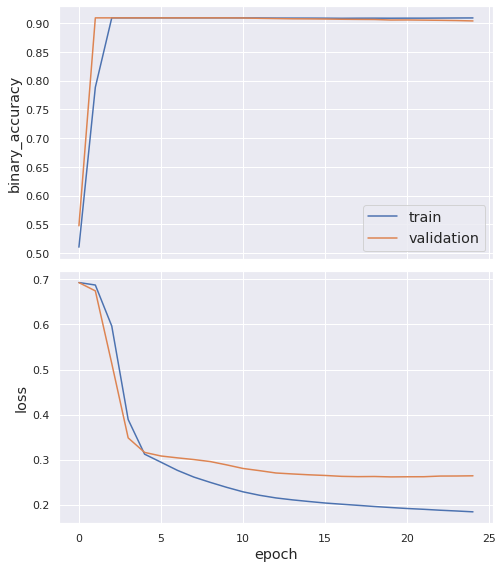

In [ ]:
# Train the model

model_history = model_model.fit(
    model_train_gen, validation_data=model_valid_gen, epochs=epochs, callbacks=[model_es]
)

sg.utils.plot_history(model_history)

In [ ]:

model_raw_ranks, model_filtered_ranks = model_complex.rank_edges_against_all_nodes(
    model_gen.flow(model_test), model_graph)

# helper function to compute metrics from a dictionary of name -> array of ranks
def results_as_dataframe(name_to_results):
    return pd.DataFrame(
        name_to_results.values(),
        columns=["mrr", "hits at 1", "hits at 3", "hits at 10"],
        index=name_to_results.keys(),
    )


def summarise(name_to_ranks):
    return results_as_dataframe(
        {
            name: (
                np.mean(1 / ranks),
                np.mean(ranks <= 1),
                np.mean(ranks < 3),
                np.mean(ranks <= 10),
            )
            for name, ranks in name_to_ranks.items()
        }
    )


summarise({"raw": model_raw_ranks, "filtered": model_filtered_ranks})

# enter pair of AAs, outputs the link most likely to exist????

,mrr,hits at 1,hits at 3,hits at 10
raw,0.017765,0.001441,0.003352,0.028087
filtered,0.072043,0.028841,0.043689,0.141423


In [ ]:

qqq = model_complex.embeddings()[1]
ppp = model_graph.edge_types

# pkl.dump(qqq, open('24Nov_50train_sparse_pretrain_edge_embeddings.p', 'wb'))
# pkl.dump(ppp, open('24Nov_50train_sparse_pretrain_edge_embedding_labels.p', 'wb'))

qqq = model_complex.embeddings()[0]
ppp = model_graph.nodes()

# pkl.dump(qqq, open('24Nov_50train_sparse_pretrain_node_embeddings.p', 'wb'))
# pkl.dump(ppp, open('24Nov_50train_sparse_pretrain_node_embedding_labels.p', 'wb'))

In [ ]:
DM['associated_positive_tuple'] = DM.apply(lambda x: tuple((x.source_mut,'positive',x.target_mut)), axis=1)
DM['associated_negative_tuple'] = DM.apply(lambda x: tuple((x.source_mut,'negative',x.target_mut)), axis=1)

DM['positive_edgetype_interpretable'] = DM.apply(lambda x: bool(x['associated_positive_tuple'][1] not in dropedgetypes), axis=1)
DM['negative_edgetype_interpretable'] = DM.apply(lambda x: bool(x['associated_negative_tuple'][1] not in dropedgetypes), axis=1)

DM = DM.loc[(DM.positive_edgetype_interpretable) & (DM.negative_edgetype_interpretable)]

In [ ]:
DM['associated_positive_tuple_string'] = DM['associated_positive_tuple'].apply(lambda x: str(x))
DM['associated_negative_tuple_string'] = DM['associated_negative_tuple'].apply(lambda x: str(x))
DM['id_number'] = DM.index.map(lambda x: x)

DM['intrain'] = DM.apply(lambda x: 0, axis = 1)
DM['invalidation'] = DM.apply(lambda x: 0, axis = 1)
DM['intest'] = DM.apply(lambda x: 0, axis = 1)

DM['intrain'].loc[DM['associated_positive_tuple_string'].isin([str(x) for x in check_train_tuples])] = 1
DM['intrain'].loc[DM['associated_negative_tuple_string'].isin([str(x) for x in check_train_tuples])] = 1
DM['invalidation'].loc[DM['associated_positive_tuple_string'].isin([str(x) for x in check_valid_tuples])] = 1
DM['invalidation'].loc[DM['associated_negative_tuple_string'].isin([str(x) for x in check_valid_tuples])] = 1
DM['intest'].loc[DM['associated_positive_tuple_string'].isin([str(x) for x in check_test_tuples])] = 1
DM['intest'].loc[DM['associated_negative_tuple_string'].isin([str(x) for x in check_test_tuples])] = 1

print(sum(DM['intrain']))
print(sum(DM['invalidation']))
print(sum(DM['intest']))

DM['intrain'].loc[(DM.intrain == 0) & (DM.invalidation == 0) & (DM.intest == 0) & (DM.id_number < int(train_fraction*len(DM)))] = 1
DM['invalidation'].loc[(DM.intrain == 0) & (DM.invalidation == 0) & (DM.intest == 0) & (DM.id_number >= int(train_fraction*len(DM))) & (DM.id_number < int(train_fraction*len(DM))+int(val_fraction*len(DM)))] = 1
DM['intest'].loc[(DM.intrain == 0) & (DM.invalidation == 0) & (DM.intest == 0)] = 1

# DM['invalidation'].loc[(DM.intrain == 0) & (DM.invalidation == 0) & (DM.intest == 0)].iloc[0:int(0.5*len(DM))] = 1
# DM['intest'].loc[(DM.intrain == 0) & (DM.invalidation == 0) & (DM.intest == 0)] = 1

print(sum(DM['intrain']))
print(sum(DM['invalidation']))
print(sum(DM['intest']))

DM.iloc[50:100]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


28597
13680
14918
267939
133475


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setit

134503


,m1_wt_aa,m1_pos,m1_mt_aa,m2_wt_aa,m2_pos,m2_mt_aa,dmlabel,smf1,smf2,dmf,epistasis,source_mut,target_mut,associated_positive_tuple,associated_negative_tuple,positive_edgetype_interpretable,negative_edgetype_interpretable,associated_positive_tuple_string,associated_negative_tuple_string,id_number,intrain,invalidation,intest
50,Y,33,N,D,47,G,NG,-1.674334,0.456999,-1.253246,-0.035911,33N,47G,"(33N, positive, 47G)","(33N, negative, 47G)",True,True,"('33N', 'positive', '47G')","('33N', 'negative', '47G')",50,1,0,0
51,L,12,Q,T,49,N,QN,-1.550821,0.148880,-1.878595,-0.476653,12Q,49N,"(12Q, positive, 49N)","(12Q, negative, 49N)",True,True,"('12Q', 'positive', '49N')","('12Q', 'negative', '49N')",51,1,0,0
52,V,29,L,F,30,Y,LY,0.243943,-0.871085,-0.602276,0.024866,29L,30Y,"(29L, positive, 30Y)","(29L, negative, 30Y)",True,True,"('29L', 'positive', '30Y')","('29L', 'negative', '30Y')",52,1,0,0
53,L,7,S,E,27,H,SH,-0.447383,-4.605170,-4.605170,0.000000,7S,27H,"(7S, positive, 27H)","(7S, negative, 27H)",True,True,"('7S', 'positive', '27H')","('7S', 'negative', '27H')",53,1,0,0
54,A,34,C,D,40,C,CC,0.036875,0.461498,-0.130722,-0.629095,34C,40C,"(34C, positive, 40C)","(34C, negative, 40C)",True,True,"('34C', 'positive', '40C')","('34C', 'negative', '40C')",54,1,0,0
55,L,7,E,T,18,S,ES,-2.008365,-0.053745,-3.756962,-1.694853,7E,18S,"(7E, positive, 18S)","(7E, negative, 18S)",True,True,"('7E', 'positive', '18S')","('7E', 'negative', '18S')",55,0,0,1
56,W,43,A,T,53,D,AD,-4.605170,-0.459391,-4.605170,0.000000,43A,53D,"(43A, positive, 53D)","(43A, negative, 53D)",True,True,"('43A', 'positive', '53D')","('43A', 'negative', '53D')",56,1,0,0
57,A,26,F,E,56,H,FH,-4.605170,-1.410586,-4.605170,0.000000,26F,56H,"(26F, positive, 56H)","(26F, negative, 56H)",True,True,"('26F', 'positive', '56H')","('26F', 'negative', '56H')",57,1,0,0
58,T,11,M,N,37,D,MD,-1.437178,-2.754984,-4.605170,-0.413008,11M,37D,"(11M, positive, 37D)","(11M, negative, 37D)",True,True,"('11M', 'positive', '37D')","('11M', 'negative', '37D')",58,1,0,0
59,L,12,V,W,43,H,VH,-1.102156,-4.605170,-4.605170,0.000000,12V,43H,"(12V, positive, 43H)","(12V, negative, 43H)",True,True,"('12V', 'positive', '43H')","('12V', 'negative', '43H')",59,1,0,0


In [ ]:
# Make a positive prediction for every DM

DM_tuples = pd.DataFrame(list(DM.associated_positive_tuple), columns=['source','label','target'])
predictions = model_model.predict(model_gen.flow(DM_tuples))

DM['positive_prediction'] = pd.DataFrame(predictions, index=DM.index)

In [ ]:
# Make a negative prediction for every DM


DM_tuples = pd.DataFrame(list(DM.associated_negative_tuple), columns=['source','label','target'])
predictions = model_model.predict(model_gen.flow(DM_tuples))

DM['negative_prediction'] = pd.DataFrame(predictions, index=DM.index)

DM['posneg_pred'] = DM.apply(lambda x: x.positive_prediction - x.negative_prediction, axis=1)

In [ ]:
DM['negmeanSMF'] = DM.apply(lambda x: -(x.smf1+x.smf2)/2, axis=1)

In [ ]:
if save_splits:

  timestamp = str(int(time.time()))

  train_edges.to_csv(f'edge_splits/train_edges_{timestamp}.csv')
  valid_edges.to_csv(f'edge_splits/valid_edges_{timestamp}.csv')
  test_edges.to_csv(f'edge_splits/test_edges_{timestamp}.csv')

  DM.to_csv(f'DM_withpredictions_{str(100*train_fraction)}_pretrain{str(pretrain_with_evc).upper()}_{timestamp}.csv')

In [ ]:

DM['m1_wt_aa_token'] = DM.apply(lambda x: ord(x.m1_wt_aa), axis=1)
DM['m1_mt_aa_token'] = DM.apply(lambda x: ord(x.m1_mt_aa), axis=1)
DM['m2_wt_aa_token'] = DM.apply(lambda x: ord(x.m2_wt_aa), axis=1)
DM['m2_mt_aa_token'] = DM.apply(lambda x: ord(x.m2_mt_aa), axis=1)

In [ ]:
evalset = DM.loc[DM.intest == 1]

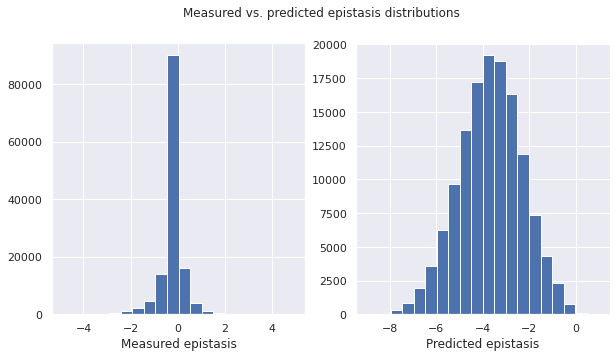

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)
ax1.hist(evalset.epistasis, bins=20)
ax1.set_xlabel('Measured epistasis')
ax2.hist(evalset.positive_prediction, bins=20)
ax2.set_xlabel('Predicted epistasis')
fig.suptitle('Measured vs. predicted epistasis distributions')
plt.show()

In [ ]:
print(len(evalset))
evalset = evalset.loc[~evalset.source_mut.isin(dropnodes)]
evalset = evalset.loc[~evalset.target_mut.isin(dropnodes)]
print(len(evalset))

134503
133751


In [ ]:
# Make a classifier integrating positive_prediction, SMF1, and SMF2

from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification


usemodel = linear_model.LinearRegression()
usemodel = RandomForestRegressor()
usemodel = RandomForestClassifier(random_state=0, n_estimators=200)
usemodel = RandomForestClassifier(random_state=0, n_estimators=400)
usemodel = RandomForestClassifier(random_state=0, n_estimators=600)
usemodel = RandomForestClassifier(random_state=0, n_estimators=1000)
usemodel = RandomForestClassifier(random_state=0, n_estimators=500)


# usemodel = linear_model.LogisticRegression(max_iter=500)
# usemodel = MLPClassifier(random_state=0)
# usemodel = svm.SVC(probability=True)

use_features = ['negative_prediction','positive_prediction','smf1','smf2','m1_pos','m2_pos','m1_wt_aa_token','m1_mt_aa_token','m2_wt_aa_token','m2_mt_aa_token']
# use_features = ['positive_prediction','smf1','smf2','m1_pos','m2_pos','m1_wt_aa_token','m1_mt_aa_token','m2_wt_aa_token','m2_mt_aa_token']
# use_features = ['negative_prediction','smf1','smf2','m1_pos','m2_pos','m1_wt_aa_token','m1_mt_aa_token','m2_wt_aa_token','m2_mt_aa_token']
# use_features = ['smf1','smf2','m1_pos','m2_pos','m1_wt_aa_token','m1_mt_aa_token','m2_wt_aa_token','m2_mt_aa_token']
# use_features = ['smf1','smf2']
# use_features = ['m1_pos','m2_pos','m1_wt_aa_token','m1_mt_aa_token','m2_wt_aa_token','m2_mt_aa_token']
# use_features = ['positive_prediction','negative_prediction','m1_pos','m2_pos','m1_wt_aa_token','m1_mt_aa_token','m2_wt_aa_token','m2_mt_aa_token']
# use_features = ['negative_prediction','m1_pos','m2_pos','m1_wt_aa_token','m1_mt_aa_token','m2_wt_aa_token','m2_mt_aa_token']




df_test_pred = evalset.copy()
df_test_pred = df_test_pred[use_features+['epistasis']]

n_tests = 1

for i in range(n_tests):

  print('\ntest '+str(i))

  train_df = DM.loc[DM['intrain']==1][use_features+['epistasis']]
  test_df = DM.loc[DM['intest']==1][use_features+['epistasis']]

  print(f'Number of train: {len(train_df)}')
  print(f'Number of test: {len(test_df)}')

  X_train = train_df.drop('epistasis',axis=1)
  X_test = test_df.drop('epistasis',axis=1)
  y_train = train_df.epistasis>positive_cutoff
  y_test = test_df.epistasis>positive_cutoff

  regr = usemodel
  regr.fit(X=X_train, y=y_train)
  pred_test = regr.predict_proba(X_test)[:,1]
  print('train acc:',regr.score(X_train,y_train))
  print('test acc:',regr.score(X_test,y_test))

  # Save predictions
  predictions = pd.DataFrame(list(X_test.index),columns=['id'])
  predictions['pred'+str(i)] = pd.DataFrame(list(pred_test))
  predictions.set_index('id',drop=True,inplace=True)

  df_test_pred = df_test_pred.merge(predictions,how='left',left_index=True, right_index=True)




test 0
Number of train: 267939
Number of test: 134503
train acc: 1.0
test acc: 0.9633242381210828


In [ ]:
if ('LinearRegression' in str(usemodel)) | ('LogisticRegression' in str(usemodel)) | ('SVM' in str(usemodel)):
  featimp = regr.coef_
if 'RandomForest' in str(usemodel):
  featimp = [regr.feature_importances_]
if 'MLP' in str(usemodel):
  featimp = [[0 for x in range(len(use_features))]]
  

featimp = pd.DataFrame(featimp, columns=use_features, index = [0])
display(featimp)

,negative_prediction,positive_prediction,smf1,smf2,m1_pos,m2_pos,m1_wt_aa_token,m1_mt_aa_token,m2_wt_aa_token,m2_mt_aa_token
0,0.077641,0.57105,0.070371,0.067894,0.043716,0.044513,0.025314,0.038293,0.022095,0.039113


In [ ]:
predcols = [f'pred{x}' for x in range(n_tests)]
if len(predcols)==1:
  df_test_pred['mean_score'] = df_test_pred['pred0']
else:
  df_test_pred['mean_score'] = df_test_pred.apply(lambda x: np.nanmean(list(x[predcols])), axis=1)
df_test_pred.dropna(axis=0,subset=['mean_score'],how='any', inplace=True)

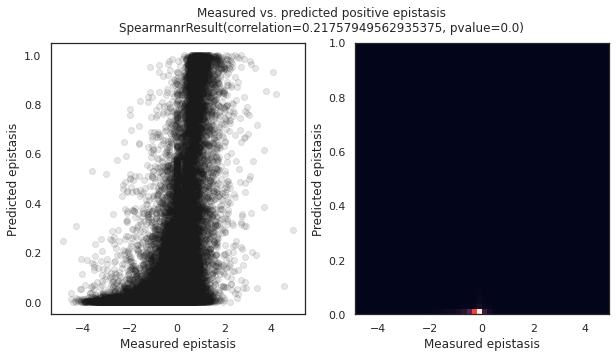

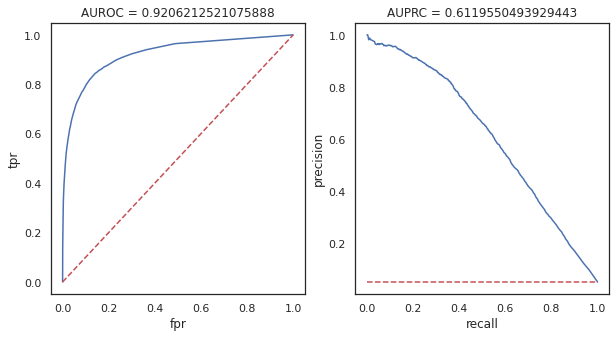

In [ ]:

a = df_test_pred.epistasis
b = df_test_pred.mean_score

spearman = str(scipy.stats.spearmanr(a,b))

fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_figheight(5)
fig.set_figwidth(10)
ax1.scatter(a, b, alpha=0.1, c='k')
ax1.set_xlabel('Measured epistasis')
ax1.set_ylabel('Predicted epistasis')
ax2.hist2d(a, b, bins=50)
ax2.set_xlabel('Measured epistasis')
ax2.set_ylabel('Predicted epistasis')
fig.suptitle(f'Measured vs. predicted positive epistasis\n{spearman}')
plt.show()


binary_epistasis = [1 if x>positive_cutoff else 0 for x in a]
binary_pred = [1 if x>0.5 else 0 for x in b]
# binary_pred = [1 if x>0.06 else 0 for x in b]


pred_all = b
y_all = binary_epistasis

fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(10,5)

fpr, tpr, thresholds = skm.roc_curve(y_all, pred_all, pos_label=1)
roc_auc = skm.auc(fpr, tpr)
# plt.figure(figsize=(5,5),facecolor='white')
ax1.plot(fpr,tpr)
ax1.plot(fpr,fpr,'r--')
ax1.set_xlabel('fpr')
ax1.set_ylabel('tpr')
ax1.set_title('AUROC = ' + str(roc_auc))

precision, recall, thresholds = skm.precision_recall_curve(y_all, pred_all, pos_label=1)
pr_auc = skm.auc(recall, precision)
# plt.figure(figsize=(5,5),facecolor='white')
ax2.plot(recall,precision)
ax2.plot([0,1],[np.mean(binary_epistasis),np.mean(binary_epistasis)],'r--')
ax2.set_xlabel('recall')
ax2.set_ylabel('precision')
ax2.set_title('AUPRC = ' + str(pr_auc))

plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix as confusion_matrix
sns.set_style('white')

PARAMETERS:
Training fraction = 0.5
Validation fraction = 0.25
Pretrain: True
Include reciprocals: True
ComplEx embedding dimension: 200
ComplEx negative samples: 10
ComplEx L2 regularization: 1e-07
Secondary model: RandomForestClassifier(n_estimators=500, random_state=0)
Features used: ['negative_prediction', 'positive_prediction', 'smf1', 'smf2', 'm1_pos', 'm2_pos', 'm1_wt_aa_token', 'm1_mt_aa_token', 'm2_wt_aa_token', 'm2_mt_aa_token']
Feature importance:


,negative_prediction,positive_prediction,smf1,smf2,m1_pos,m2_pos,m1_wt_aa_token,m1_mt_aa_token,m2_wt_aa_token,m2_mt_aa_token
0,0.077641,0.57105,0.070371,0.067894,0.043716,0.044513,0.025314,0.038293,0.022095,0.039113



RESULTS:
AUROC = 0.9206212521075888
AUPRC = 0.6119550493929443
F1 = 0.5252817104882983
Precision = 0.7688187200451085
Recall = 0.3989174956114687
Accuracy = 0.9631479390808293
Confusion matrix:
 [[126095    820]
 [  4109   2727]]


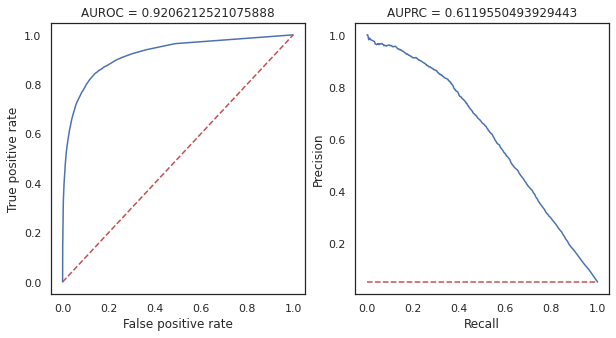

In [ ]:
print('PARAMETERS:')
print(f'Training fraction = {train_fraction}')
print(f'Validation fraction = {val_fraction}')
print(f'Pretrain: {pretrain_with_evc}')
print(f'Include reciprocals: {use_recips}')
print(f'ComplEx embedding dimension: {embedding_dimension}')
print(f'ComplEx negative samples: {negative_samples}')
print(f'ComplEx L2 regularization: {l2reg}')


print(f'Secondary model: {str(usemodel)}')
print(f'Features used: {use_features}')
print(f'Feature importance:')
display(featimp)

print('\nRESULTS:')
print(f'AUROC = {roc_auc}')
print(f'AUPRC = {pr_auc}')
print(f'F1 = {skm.f1_score(binary_epistasis, binary_pred)}')
print(f'Precision = {skm.precision_score(binary_epistasis, binary_pred)}')
print(f'Recall = {skm.recall_score(binary_epistasis, binary_pred)}')
print(f'Accuracy = {skm.accuracy_score(binary_epistasis, binary_pred)}')
print(f'Confusion matrix:\n {confusion_matrix(binary_epistasis, binary_pred)}')

fig,(ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(10,5)
fpr, tpr, thresholds = skm.roc_curve(y_all, pred_all, pos_label=1)
roc_auc = skm.auc(fpr, tpr)
ax1.plot(fpr,tpr)
ax1.plot(fpr,fpr,'r--')
ax1.set_xlabel('False positive rate')
ax1.set_ylabel('True positive rate')
ax1.set_title('AUROC = ' + str(roc_auc))
precision, recall, thresholds = skm.precision_recall_curve(y_all, pred_all, pos_label=1)
pr_auc = skm.auc(recall, precision)
ax2.plot(recall,precision)
ax2.plot([0,1],[np.mean(binary_epistasis),np.mean(binary_epistasis)],'r--')
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('AUPRC = ' + str(pr_auc))
plt.show()

Text(0.5, 257.44, 'Predicted label')

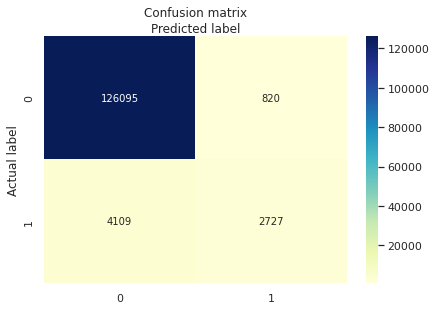

In [ ]:

aa = [1 if x>positive_cutoff else 0 for x in a]
bb = [1 if x>0.5 else 0 for x in b]



cnf_matrix = confusion_matrix(aa, bb)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

Text(0.5, 0.98, '1PGA')

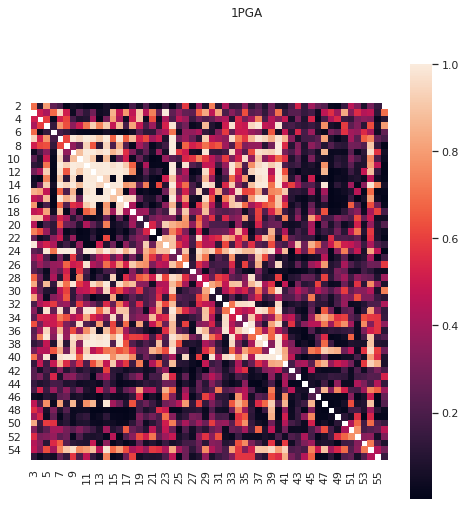

In [ ]:
df_episcore = pd.DataFrame()

for i in range(56):
  for j in range(56):
    scorelist = list(df_test_pred.loc[(df_test_pred['m1_pos']==i) & (df_test_pred['m2_pos']==j)]['mean_score'])
    scorelist += list(df_test_pred.loc[(df_test_pred['m1_pos']==j) & (df_test_pred['m2_pos']==i)]['mean_score'])
    try:
      score = np.max(scorelist)
      df_episcore.loc[i,j] = score
    except:
      pass

f, ax = plt.subplots(1,1,figsize=(8, 8), facecolor='white')
ax = sns.heatmap(df_episcore, square = True)

f.suptitle(pdbid)